<a href="https://colab.research.google.com/github/ferdouszislam/Bangla-Handwritting-Aesthetics-Prediction-ML/blob/main/codes/experimentation_5_class_cs_learning_with_label_probs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import time
import copy
import torch
import numpy as np
import math
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from skimage import io
import matplotlib.pyplot as plt

In [2]:
# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
# mount gdrive with this code
from google.colab import drive
drive.mount('/content/drive')

# extract the zip file containing our dataset
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/BanglaLekha-Isolated_aesthetics_dataset/5_class.zip', 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Mounted at /content/drive


In [4]:
# set all random seeds
SEED = 42

def set_global_seed():
  #torch.backends.cudnn.deterministic = True
  #torch.backends.cudnn.benchmark = False
  #random.seed(SEED)
  torch.manual_seed(SEED)
  torch.cuda.manual_seed(SEED)
  torch.cuda.manual_seed_all(SEED)
  #np.random.seed(SEED)

set_global_seed()

In [5]:
# custom dataset class
class BanglaLekhaAesScoreLabledDataset(Dataset):
  def __init__(self, labels_csv_file, img_dir, transform=None):
    self.labels_df = pd.read_csv(labels_csv_file)
    self.img_dir = img_dir
    self.transform = transform

  def __len__(self):
    return len(self.labels_df)

  def __getitem__(self, index):
    img_path = os.path.join(self.img_dir, self.labels_df.iloc[index, 0])
    image = io.imread(img_path)
    if self.transform:
      image = self.transform(image)
    
    y_label = torch.tensor(self.labels_df.iloc[index, 2:7])
    #print(y_label)
    
    return (image, y_label)

In [6]:
# load data

# resize to same shape and convert to tensor
custom_transform = transforms.Compose([transforms.ToPILImage(), 
                                       transforms.Resize((50, 50)), 
                                       transforms.ToTensor(),
                                       #transforms.Normalize((0.5,), (0.5,))
                                       ])

train_dataset = BanglaLekhaAesScoreLabledDataset(labels_csv_file='/tmp/5_class/scoreLabel_train.csv', 
                                        img_dir='/tmp/5_class/train_images', transform=custom_transform)
val_dataset = BanglaLekhaAesScoreLabledDataset(labels_csv_file='/tmp/5_class/scoreLabel_val.csv', 
                                        img_dir='/tmp/5_class/validation_images', transform=custom_transform)
test_dataset = BanglaLekhaAesScoreLabledDataset(labels_csv_file='/tmp/5_class/scoreLabel_test.csv', 
                                        img_dir='/tmp/5_class/test_images', transform=custom_transform)

# data loaders

batch_size = 100 # no of samples in a single batch

set_global_seed()
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
set_global_seed()
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
# visualize data
def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (25,4))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=25).permute(1,2,0))
        #print(images.shape)
        break

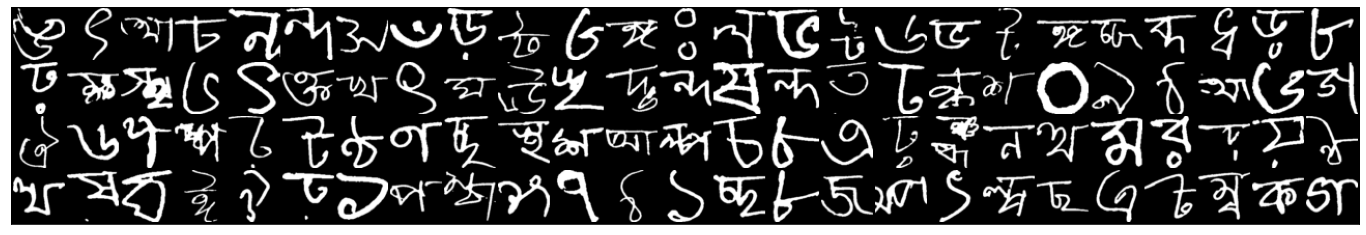

In [8]:
show_batch(val_loader)

In [9]:
# hyperparameters
INPUT_SIZE = 50*50
ANN_FC1_SIZE = 256
ANN_FC2_SIZE = 128
ANN_FC3_SIZE = 64
CONV1_FILTERS = 16
CONV2_FILTERS = 32
NUM_EPOCHS = 40
LEARNING_RATE = 0.001

In [10]:
# custom ANN class with 3 hidden layers, relu activation and dropout on each hidden layer
class ANN(nn.Module):
  def __init__(self, input_size=INPUT_SIZE, fc1_size=256, fc2_size=128, fc3_size=64):
    super(ANN, self).__init__()
    self.input_size = input_size
    self.fc1 = nn.Linear(input_size, fc1_size)
    self.dropout_fc1 = nn.Dropout(0.75)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(fc1_size, fc2_size)
    self.dropout_fc2 = nn.Dropout(0.5)
    self.fc3 = nn.Linear(fc2_size, fc3_size)
    self.dropout_fc3 = nn.Dropout(0.5)
    self.output_layer = nn.Linear(fc3_size, 5)

  def forward(self, input):
    # flatten input
    input = input.reshape(-1, self.input_size) 
    # input layer to hidden layer 1
    output = self.dropout_fc1(self.fc1(input))
    output = self.relu(output)
    # hidden layer 1 to hidden layer 2
    output = self.dropout_fc2(self.fc2(output))
    output = self.relu(output)
    # hidden layer 2 to hidden layer 3
    output = self.dropout_fc3(self.fc3(output))
    output = self.relu(output)
    # hidden layer 3 to output
    output = self.output_layer(output)
    output = self.relu(output)
    return output

In [11]:
# custom cnn class 
class CNN(nn.Module):
  def __init__(self, conv1_filters=16, conv2_filters=32, fc1_size=256, fc2_size=64):
    super(CNN, self).__init__()
    
    self.conv1_filters = conv1_filters
    self.conv2_filters = conv2_filters

    self.conv_layer1 = nn.Sequential(
        nn.Conv2d(1, conv1_filters, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(conv1_filters),
        nn.Dropout(0.25),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.conv_layer2 =  nn.Sequential(
        nn.Conv2d(conv1_filters, conv2_filters, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(conv2_filters),
        nn.Dropout(0.25),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    # conv layer explanation with: conv1_filters=16, conv2_filters=32
    # 1x50x50 --conv1--> 16x50x50 --maxpool--> 16x25x25
    # 16x25x25 --conv2--> 32x25x25 --maxpool--> 32x12x12

    self.fc1 = nn.Linear(conv2_filters*12*12, fc1_size) 
    self.fc2 = nn.Linear(fc1_size, fc2_size)
    self.relu = nn.ReLU()
    self.fc_dropout = nn.Dropout(0.5)
    self.output_layer = nn.Linear(fc2_size, 5)
      
  def forward(self, input):
    #print('inside forward', input.shape)

    # input to conv_layer1
    output = self.conv_layer1(input)
    #print('after conv1', output.shape)

    # conv_layer1 to conv_layer2
    output = self.conv_layer2(output)
    #print('after conv2', output.shape)

    # conv_layer2 to fc1
    output = output.reshape(-1, self.conv2_filters*12*12) # flatten
    output = self.fc1(output)
    output = self.relu(self.fc_dropout(output))

    # fc1 to fc2
    output = self.fc2(output)
    output = self.relu(self.fc_dropout(output))

    # fc2 to prediction
    output = self.output_layer(output)
    output = self.relu(output)

    return output

  def _get_result_dims(input_dims, conv_dims, p=0, s=1):
    # get resulting matrix(2d) dimensions after convolution
    
    resulting_dims = []
    resulting_dims.append(int((input_dims[0] - conv_dims[0] + 2*p)/s)+1)
    resulting_dims.append(int((input_dims[1] - conv_dims[1] + 2*p)/s)+1)
    
    return resulting_dims

In [12]:
# class to calculate f1 score supporting average, macro, micro f1 score for multi-classes

from typing import Tuple

class F1Score:
    """
    Class for f1 calculation in Pytorch.
    
    courtesy- <https://stackoverflow.com/questions/62265351/measuring-f1-score-for-multiclass-classification-natively-in-pytorch> 
    
    """

    def __init__(self, average: str = 'weighted'):
        """
        Init.

        Args:
            average: averaging method
        """
        self.average = average
        if average not in [None, 'micro', 'macro', 'weighted']:
            raise ValueError('Wrong value of average parameter')

    def _calc_f1_micro(self, predictions: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        """
        Calculate f1 micro.

        Args:
            predictions: tensor with predictions
            labels: tensor with original labels

        Returns:
            f1 score
        """
        true_positive = torch.eq(labels, predictions).sum().float()
        f1_score = torch.div(true_positive, len(labels))
        return f1_score

    def _calc_f1_count_for_label(self, predictions: torch.Tensor,
                                labels: torch.Tensor, label_id: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Calculate f1 and true count for the label

        Args:
            predictions: tensor with predictions
            labels: tensor with original labels
            label_id: id of current label

        Returns:
            f1 score and true count for label
        """
        # label count
        true_count = torch.eq(labels, label_id).sum()

        # true positives: labels equal to prediction and to label_id
        true_positive = torch.logical_and(torch.eq(labels, predictions),
                                          torch.eq(labels, label_id)).sum().float()
        # precision for label
        precision = torch.div(true_positive, torch.eq(predictions, label_id).sum().float())
        # replace nan values with 0
        precision = torch.where(torch.isnan(precision),
                                torch.zeros_like(precision).type_as(true_positive),
                                precision)

        # recall for label
        recall = torch.div(true_positive, true_count)
        # f1
        f1 = 2 * precision * recall / (precision + recall)
        # replace nan values with 0
        f1 = torch.where(torch.isnan(f1), torch.zeros_like(f1).type_as(true_positive), f1)
        
        # print(f'for class {label_id}: precision={precision:.2f}, recall={recall:.2f}, f1={f1:.2f}, TP={true_positive}, freq={true_count}')
        
        return f1, true_count

    def __call__(self, predictions: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        """
        Calculate f1 score based on averaging method defined in init.

        Args:
            predictions: tensor with predictions
            labels: tensor with original labels

        Returns:
            f1 score
        """

        # simpler calculation for micro
        if self.average == 'micro':
            return self._calc_f1_micro(predictions, labels)

        f1_score = 0
        for label_id in range(1, len(labels.unique()) + 1):
            f1, true_count = self._calc_f1_count_for_label(predictions, labels, label_id)

            if self.average == 'weighted':
                f1_score += f1 * true_count
            elif self.average == 'macro':
                f1_score += f1

        if self.average == 'weighted':
            f1_score = torch.div(f1_score, len(labels))
        elif self.average == 'macro':
            f1_score = torch.div(f1_score, len(labels.unique()))

        return f1_score

In [13]:
# class for calculating per class accuracy
class PerClassAccCalc():
  def __init__(self, num_classes=5):
    self.num_classes = num_classes
    self.gt_label_freq = [0 for i in range(num_classes)]
    self.correct_pred_freq = [0 for i in range(num_classes)]

  def add_batch(self, pred_labels, gt_labels):
    for curr_cls in range(self.num_classes):
      self.gt_label_freq[curr_cls] += gt_labels.eq(curr_cls).sum().item()
      self.correct_pred_freq[curr_cls] += torch.logical_and(pred_labels==gt_labels, pred_labels==curr_cls).sum().item()

  def get_classwise_acc(self):
    accs = []
    for curr_cls in range(self.num_classes):
      # print(curr_cls, self.correct_pred_freq[curr_cls], self.gt_label_freq[curr_cls])
      acc = (self.correct_pred_freq[curr_cls] / self.gt_label_freq[curr_cls]) * 100.00
      accs.append(round(acc, 3))
    return accs

In [14]:
def train(model, optimizer, criterion, train_loader, val_loader, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    min_val_loss = np.inf
    
    curr_train_acc = 0.0
    curr_train_loss = 0.0
    curr_train_f1 = 0.0
    curr_val_acc = 0.0
    curr_val_loss = 0.0
    curr_val_f1 = 0.0
    
    selected_epoch = 0
    selected_train_acc = 0.0
    selected_train_f1 = 0.0
    selected_val_acc = 0.0
    selected_val_f1 = 0.0

    train_accs = []
    val_accs = []
    train_losses = []
    val_losses = []
    train_f1s = []
    val_f1s = []

    f1_score_calc = F1Score('macro')

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 15)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_f1 = 0.0

            data_loader = train_loader if phase == 'train' else val_loader

            # Iterate over data.
            for inputs, label_probs in data_loader:
                inputs = inputs.to(device)
                label_probs = label_probs.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    _, labels = torch.max(label_probs, 1)
                    loss = criterion(outputs, label_probs)

                    # print(preds.shape, labels.shape)
                    # print(preds, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() #* inputs.size(0)
                running_corrects += torch.sum(preds == labels)
                running_f1 += f1_score_calc(preds, labels)

            epoch_loss = running_loss / len(data_loader)
            epoch_acc = running_corrects.double() / len(data_loader)
            epoch_f1 = running_f1 / len(data_loader)

            if phase == 'train':
              curr_train_acc = epoch_acc
              curr_train_loss = epoch_loss
              curr_train_f1 = epoch_f1
              train_accs.append(epoch_acc)
              train_losses.append(epoch_loss)
              train_f1s.append(epoch_f1)
            else:
              curr_val_acc = epoch_acc
              curr_val_loss = epoch_loss
              curr_val_f1 = epoch_f1
              val_accs.append(epoch_acc)
              val_losses.append(epoch_loss)
              val_f1s.append(epoch_f1)

            print('{} Loss: {:.4f} Acc: {:.4f}, Macro F1: {:.4f}'.format(
                phase, epoch_loss, epoch_acc, epoch_f1))

            if phase == 'val':
              # deep copy the model
              if curr_val_loss < min_val_loss or (curr_val_loss == min_val_loss and curr_val_acc > selected_val_acc):
                min_val_loss = curr_val_loss
                selected_epoch = epoch

                selected_train_acc = curr_train_acc
                selected_train_f1 = curr_train_f1
                selected_val_acc = curr_val_acc
                selected_val_f1 = curr_val_f1

                best_model_wts = copy.deepcopy(model.state_dict())
                
                print('Minimum validation loss reduced \t Saving Model!')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Train Accuracy: {:.4f}, Macro F1-score: {:.4f}'.format(selected_train_acc, selected_train_f1))
    print('Validation Accuracy: {:.4f}, Macro F1-score: {:.4f}'.format(selected_val_acc, selected_val_f1))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, selected_epoch, train_accs, train_losses, train_f1s, val_accs, val_losses, val_f1s

# evaluation 
def eval(model, test_loader):
  model.eval()
  
  f1_score_calc = F1Score('macro')
  per_cls_acc = PerClassAccCalc(num_classes=5)

  with torch.no_grad():
    running_corrects = 0
    running_f1 = 0.0

    # Iterate over data.
    for inputs, label_probs in test_loader:
        inputs = inputs.to(device)
        label_probs = label_probs.to(device)

        # predict
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        _, labels = torch.max(label_probs, 1)

        # statistics
        running_corrects += torch.sum(preds == labels)
        running_f1 += f1_score_calc(preds, labels)
        per_cls_acc.add_batch(preds, labels)

    test_acc = running_corrects.double() / len(test_loader)
    test_f1 = running_f1 / len(test_loader)
    per_class_accuracies = per_cls_acc.get_classwise_acc()

    print(f'Test Accuracy: {test_acc:0.3f}, Test Macro F1: {test_f1:0.3f}')
    print(f'Classwise accuracies: {per_class_accuracies}')

# plot lists of train, validation scores- accuracy, loss etc
def plot_scores(score_type, train_scores, val_scores, num_epochs=NUM_EPOCHS, selected_epoch=None):
  plt.figure(figsize =(15,9))
  plt.title(f"train vs validation {score_type}", fontdict = {'fontsize' : 18})
  epochs = [epoch for epoch in range(num_epochs)]
  plt.plot(epochs, train_scores, 'ro-',  epochs, val_scores ,'bv-')

  if selected_epoch:
    plt.axvline(x=selected_epoch, color='k', linestyle='--')
    plt.legend([f'train {score_type}',f'validation {score_type}', 'selected epoch'], fontsize=16)
  
  plt.xlabel('epochs', fontsize=18)
  plt.ylabel(score_type, fontsize=18)
  plt.xticks(fontsize=18)
  plt.yticks(fontsize=18)
  plt.show()

# **Cost Sensitive Learning Method-1: Weighted Loss Function**

In [15]:
# setup the loss function with weights based on frequency of sample belonging to a class

# sample count in dataset
score_1_sample_count = 37121.0
score_2_sample_count = 49851.0
score_3_sample_count = 49931.0
score_4_sample_count = 26347.0
score_5_sample_count = 2855.0

def get_class_weight(class_sample_cnt):
  TOTAL_SAMPLE_COUNT = 166105.0
  return TOTAL_SAMPLE_COUNT / (5.0 * class_sample_cnt);

class_weights_list = [get_class_weight(score_1_sample_count), 
                      get_class_weight(score_2_sample_count),
                      get_class_weight(score_3_sample_count),
                      get_class_weight(score_4_sample_count),
                      get_class_weight(score_5_sample_count)]

class_weights_tensor = torch.FloatTensor(class_weights_list).to(device)
# softmax = nn.Softmax(dim=0)
# class_weights_tensor = softmax(class_weights_tensor)
# class_weights_tensor /= 10
sigmoid = nn.Sigmoid()
class_weights_tensor = sigmoid(class_weights_tensor)

print(class_weights_tensor)

tensor([0.9036, 0.8410, 0.8407, 0.9590, 1.0000], device='cuda:0')


In [16]:
# custom cross entropy loss with class_weights
class CrossEntropyWithClassWeights(nn.Module):
  def __init__(self, class_weights=[1.0, 1.0, 1.0, 1.0, 1.0]):
    super(CrossEntropyWithClassWeights, self).__init__()
    self.class_weights = class_weights

  def forward(self, outputs, targets):
    #print(outputs, targets)

    _, labels = torch.max(targets, 1)
    labels = labels.float()
    # print(labels.type())
    weights_tensor = torch.ones_like(labels).to(device)
    for curr_class in range(5):
      curr_class_tensor = torch.full(labels.size(), curr_class).to(device)
      curr_class_weight = self.class_weights[curr_class]
      curr_class_weight_tensor = torch.full(labels.size(), curr_class_weight).to(device)
      weights_tensor = torch.where(labels==curr_class_tensor, curr_class_weight_tensor, weights_tensor).to(device)

    num_examples = targets.shape[0]
    cross_entropies = targets*self._log_softmax(outputs)
    # collapse cross_entropies of shape (batch_size, 5) to shape (batch_size, 1) by taking their sum
    # then multiply with weights_tensor
    cross_entropies = torch.sum(cross_entropies, dim=1) * weights_tensor

    return - torch.sum(cross_entropies) / num_examples

  def _log_softmax(self, x):
    return x - torch.logsumexp(x,dim=1, keepdim=True)

In [17]:
# setup the loss function with class weights
cs1_criterion = CrossEntropyWithClassWeights(class_weights=class_weights_tensor.tolist())

## Custom ANN

In [18]:
# # init model with ANN
# set_global_seed()
# model = ANN(input_size=INPUT_SIZE, fc1_size=ANN_FC1_SIZE, fc2_size=ANN_FC2_SIZE, fc3_size=ANN_FC3_SIZE)
# model = model.to(device)

# # init optimizer
# optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# model,selected_epoch, train_accs,train_losses,train_f1s, val_accs,val_losses,val_f1s = train(model, optimizer, cs1_criterion, train_loader, val_loader, NUM_EPOCHS)

In [19]:
#plot_scores('accuracy', train_accs, val_accs, NUM_EPOCHS, selected_epoch)

In [20]:
#plot_scores('loss', train_losses, val_losses, NUM_EPOCHS, selected_epoch)

In [21]:
#plot_scores('macro f1-score', train_f1s, val_f1s, NUM_EPOCHS, selected_epoch)

In [22]:
# eval(model=model, test_loader=test_loader)

## Custom CNN

In [23]:
# init model with CNN
set_global_seed()
model = CNN()
model = model.to(device)

# init optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

model,selected_epoch, train_accs,train_losses,train_f1s, val_accs,val_losses,val_f1s = train(model, optimizer, cs1_criterion, train_loader, val_loader, NUM_EPOCHS)

Epoch 0/39
---------------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 1.2356 Acc: 35.5323, Macro F1: 0.1636
val Loss: 1.2808 Acc: 31.8084, Macro F1: 0.0830
Minimum validation loss reduced 	 Saving Model!

Epoch 1/39
---------------
train Loss: 1.1862 Acc: 39.1959, Macro F1: 0.1899
val Loss: 1.1873 Acc: 37.4444, Macro F1: 0.1472
Minimum validation loss reduced 	 Saving Model!

Epoch 2/39
---------------
train Loss: 1.1645 Acc: 40.3711, Macro F1: 0.2032
val Loss: 1.2268 Acc: 35.7893, Macro F1: 0.1191

Epoch 3/39
---------------
train Loss: 1.1520 Acc: 40.9400, Macro F1: 0.2067
val Loss: 1.1937 Acc: 36.8161, Macro F1: 0.1348

Epoch 4/39
---------------
train Loss: 1.1384 Acc: 41.4864, Macro F1: 0.2152
val Loss: 1.2373 Acc: 31.8046, Macro F1: 0.0889

Epoch 5/39
---------------
train Loss: 1.1290 Acc: 41.9306, Macro F1: 0.2179
val Loss: 1.1598 Acc: 40.1762, Macro F1: 0.1713
Minimum validation loss reduced 	 Saving Model!

Epoch 6/39
---------------
train Loss: 1.1191 Acc: 42.5951, Macro F1: 0.2249
val Loss: 1.1502 Acc: 41.7816, Macro F1: 0.1918
Mi

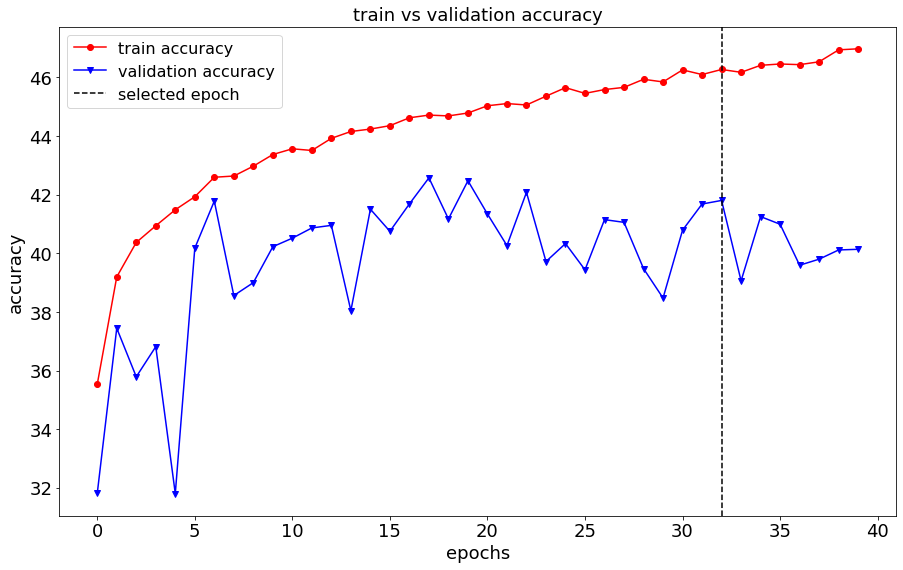

In [24]:
plot_scores('accuracy', train_accs, val_accs, NUM_EPOCHS, selected_epoch)

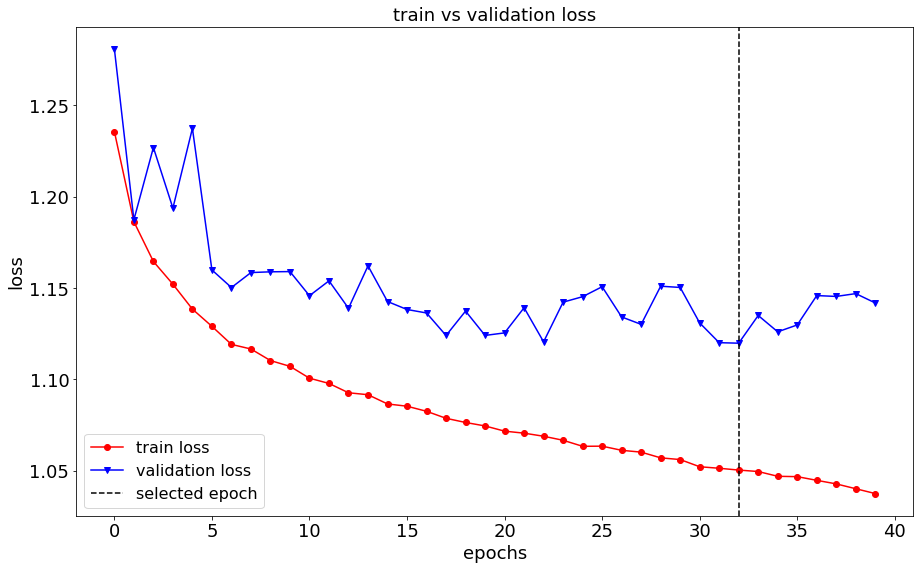

In [25]:
plot_scores('loss', train_losses, val_losses, NUM_EPOCHS, selected_epoch)

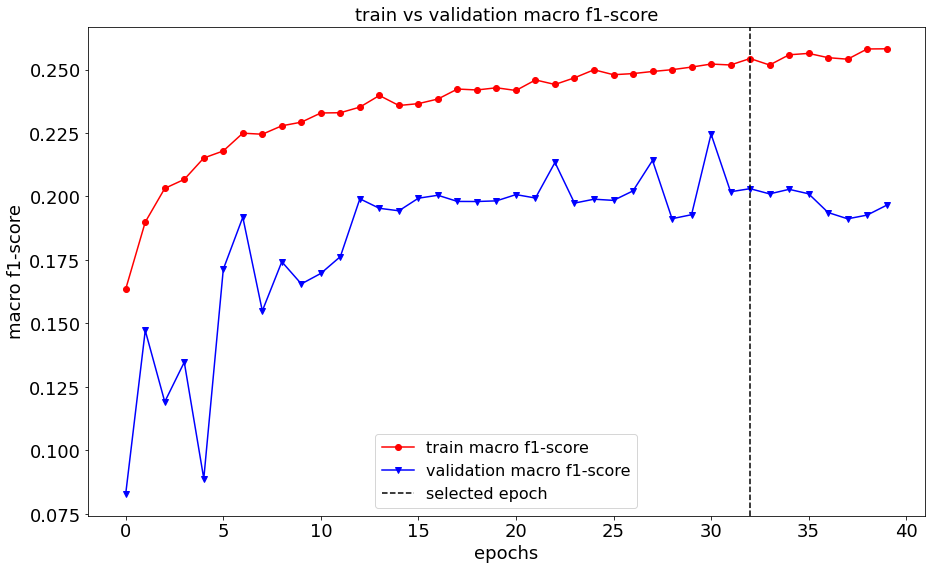

In [26]:
plot_scores('macro f1-score', train_f1s, val_f1s, NUM_EPOCHS, selected_epoch)

In [27]:
eval(model=model, test_loader=test_loader)

Test Accuracy: 41.066, Test Macro F1: 0.196
Classwise accuracies: [19.201, 56.46, 66.887, 0.0, 0.0]


## Transfer Learning

In [28]:
from torchvision import models

In [29]:
# resize to same shape and convert to tensor
tm_transform = transforms.Compose([transforms.ToPILImage(), 
                                   transforms.Resize((224, 224)),
                                   transforms.ToTensor(),
                                   transforms.Lambda(lambda img: img.repeat(3, 1, 1) ), # repeat single channel thrice to get 3-channel 
                                   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                   ])

# load datasets
tm_train_dataset = BanglaLekhaAesScoreLabledDataset(labels_csv_file='/tmp/5_class/scoreLabel_train.csv', 
                                        img_dir='/tmp/5_class/train_images', transform=tm_transform)
tm_val_dataset = BanglaLekhaAesScoreLabledDataset(labels_csv_file='/tmp/5_class/scoreLabel_val.csv', 
                                        img_dir='/tmp/5_class/validation_images', transform=tm_transform)
tm_test_dataset = BanglaLekhaAesScoreLabledDataset(labels_csv_file='/tmp/5_class/scoreLabel_test.csv', 
                                        img_dir='/tmp/5_class/test_images', transform=tm_transform)

# data-loaders

batch_size = 100 # no of samples in a single batch

set_global_seed()
tm_train_loader = DataLoader(dataset=tm_train_dataset, batch_size=batch_size, shuffle=True)
set_global_seed()
tm_val_loader = DataLoader(dataset=tm_val_dataset, batch_size=batch_size, shuffle=True)
tm_test_loader = DataLoader(dataset=tm_test_dataset, batch_size=batch_size, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


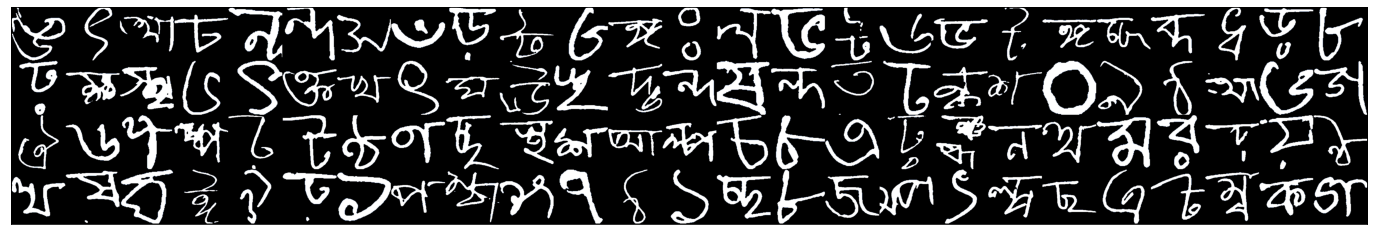

In [30]:
show_batch(tm_val_loader)

In [31]:
class TransferModel(nn.Module):
  def __init__(self, model_name='resnet-18'):
    super(TransferModel, self).__init__()
    
    if model_name == 'resnet-18':
      self.base_model = models.resnet18(pretrained=True)
    elif model_name == 'alexnet':
      self.base_model = models.alexnet(pretrained=True)
    elif model_name == 'squeezenet':
      self.base_model = models.squeezenet1_1(pretrained=True)
    
    # freeze resnet beginning layers
    for param in self.base_model.parameters():
      param.requires_grad = False

    # output to one neuron
    if model_name == 'resnet-18':
      self.base_model.fc = nn.Linear(self.base_model.fc.in_features, 5)
    elif model_name == 'alexnet':
      self.base_model.classifier[6] = nn.Linear(self.base_model.classifier[6].in_features, 5)
    elif model_name == 'squeezenet':
      self.base_model.classifier._modules["1"] = nn.Conv2d(512, 5, kernel_size=(1, 1))


  def forward(self, input):
    output = self.base_model(input)
    return output

### Resnet-18

In [32]:
# init model with ResNet-18
set_global_seed()

model = TransferModel('resnet-18')
model = model.to(device)

# init optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

model,selected_epoch, train_accs,train_losses,train_f1s, val_accs,val_losses,val_f1s = train(model, optimizer, cs1_criterion, tm_train_loader, tm_val_loader, NUM_EPOCHS)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Epoch 0/39
---------------
train Loss: 1.1940 Acc: 37.9353, Macro F1: 0.1871
val Loss: 1.1736 Acc: 38.6398, Macro F1: 0.2040
Minimum validation loss reduced 	 Saving Model!

Epoch 1/39
---------------
train Loss: 1.1682 Acc: 39.7301, Macro F1: 0.1994
val Loss: 1.2017 Acc: 34.3372, Macro F1: 0.1686

Epoch 2/39
---------------
train Loss: 1.1646 Acc: 39.9269, Macro F1: 0.2002
val Loss: 1.1741 Acc: 39.2989, Macro F1: 0.1895

Epoch 3/39
---------------
train Loss: 1.1623 Acc: 40.1612, Macro F1: 0.2035
val Loss: 1.1731 Acc: 38.2989, Macro F1: 0.1925
Minimum validation loss reduced 	 Saving Model!

Epoch 4/39
---------------
train Loss: 1.1619 Acc: 40.2559, Macro F1: 0.2023
val Loss: 1.1655 Acc: 39.0881, Macro F1: 0.2173
Minimum validation loss reduced 	 Saving Model!

Epoch 5/39
---------------
train Loss: 1.1600 Acc: 40.2287, Macro F1: 0.2036
val Loss: 1.1695 Acc: 38.8046, Macro F1: 0.1999

Epoch 6/39
---------------
train Loss: 1.1589 Acc: 40.2559, Macro F1: 0.2058
val Loss: 1.1642 Acc: 3

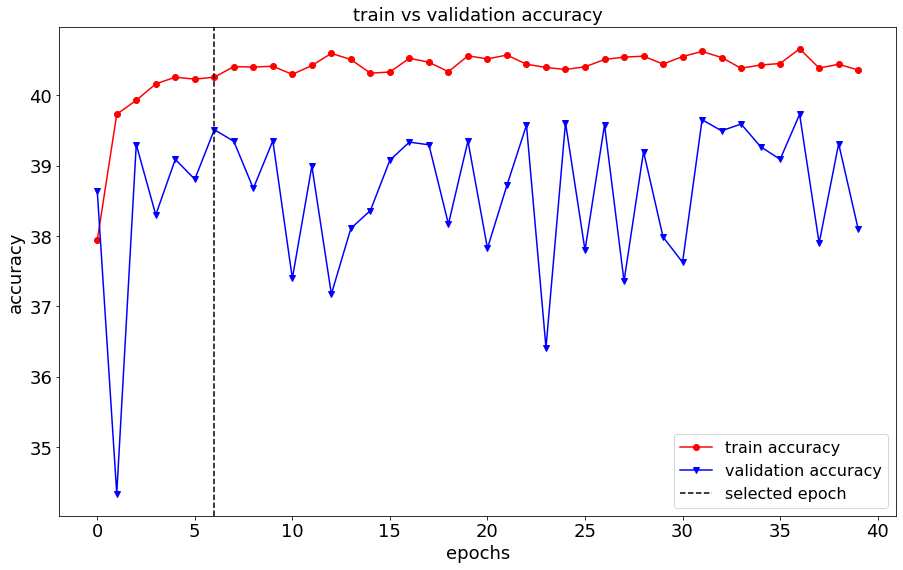

In [33]:
plot_scores('accuracy', train_accs, val_accs, NUM_EPOCHS, selected_epoch)

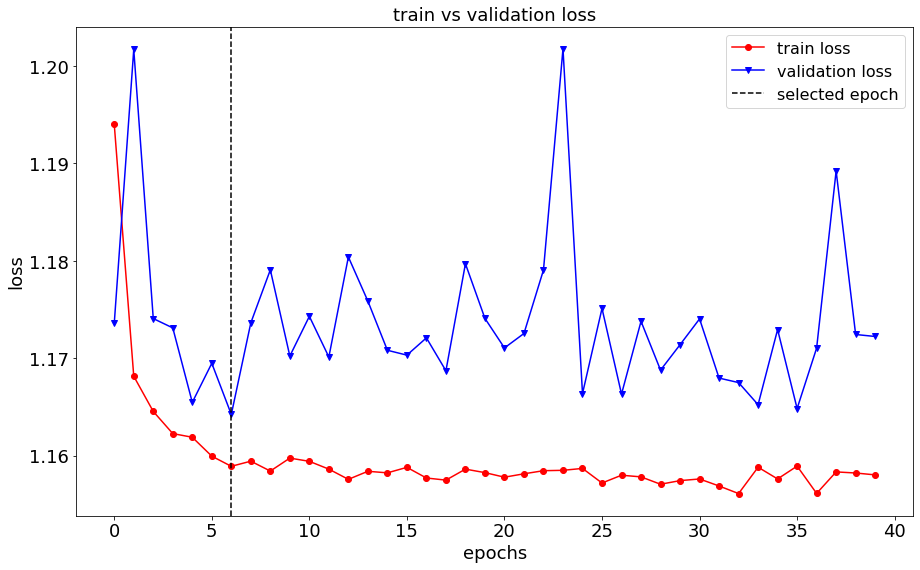

In [34]:
plot_scores('loss', train_losses, val_losses, NUM_EPOCHS, selected_epoch)

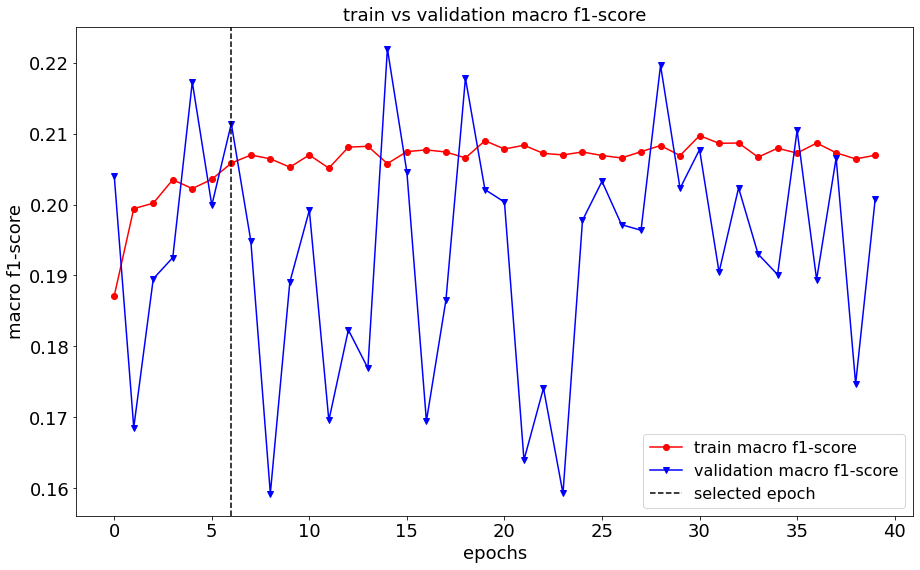

In [35]:
plot_scores('macro f1-score', train_f1s, val_f1s, NUM_EPOCHS, selected_epoch)

In [36]:
eval(model=model, test_loader=tm_test_loader)

Test Accuracy: 39.183, Test Macro F1: 0.206
Classwise accuracies: [38.563, 51.105, 43.631, 14.472, 0.0]


### Alexnet

In [37]:
# # init model with alexnet
# set_global_seed()

# model = TransferModel('alexnet')
# model = model.to(device)

# # init optimizer
# optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# model,selected_epoch, train_accs,train_losses,train_f1s, val_accs,val_losses,val_f1s = train(model, optimizer, cs1_criterion, tm_train_loader, tm_val_loader, NUM_EPOCHS)

In [38]:
# plot_scores('accuracy', train_accs, val_accs, NUM_EPOCHS, selected_epoch)

In [39]:
# plot_scores('loss', train_losses, val_losses, NUM_EPOCHS, selected_epoch)

In [40]:
# plot_scores('macro f1-score', train_f1s, val_f1s, NUM_EPOCHS, selected_epoch)

In [41]:
# eval(model=model, test_loader=tm_test_loader)

### SqueezeNet

In [42]:
# init model with squeezenet
set_global_seed()

model = TransferModel('squeezenet')
model = model.to(device)

# init optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

model,selected_epoch, train_accs,train_losses,train_f1s, val_accs,val_losses,val_f1s = train(model, optimizer, cs1_criterion, tm_train_loader, tm_val_loader, NUM_EPOCHS)

Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth


  0%|          | 0.00/4.73M [00:00<?, ?B/s]

Epoch 0/39
---------------
train Loss: 1.2052 Acc: 37.8341, Macro F1: 0.1900
val Loss: 1.1971 Acc: 37.5632, Macro F1: 0.1886
Minimum validation loss reduced 	 Saving Model!

Epoch 1/39
---------------
train Loss: 1.1755 Acc: 39.4246, Macro F1: 0.2000
val Loss: 1.1731 Acc: 39.4751, Macro F1: 0.1824
Minimum validation loss reduced 	 Saving Model!

Epoch 2/39
---------------
train Loss: 1.1701 Acc: 39.7170, Macro F1: 0.2021
val Loss: 1.1784 Acc: 38.6628, Macro F1: 0.1914

Epoch 3/39
---------------
train Loss: 1.1665 Acc: 39.9494, Macro F1: 0.2012
val Loss: 1.1662 Acc: 38.8506, Macro F1: 0.1982
Minimum validation loss reduced 	 Saving Model!

Epoch 4/39
---------------
train Loss: 1.1656 Acc: 39.8641, Macro F1: 0.2027
val Loss: 1.1967 Acc: 38.1839, Macro F1: 0.1880

Epoch 5/39
---------------
train Loss: 1.1638 Acc: 40.1940, Macro F1: 0.2061
val Loss: 1.1757 Acc: 38.7778, Macro F1: 0.1968

Epoch 6/39
---------------
train Loss: 1.1643 Acc: 40.0834, Macro F1: 0.2049
val Loss: 1.1784 Acc: 3

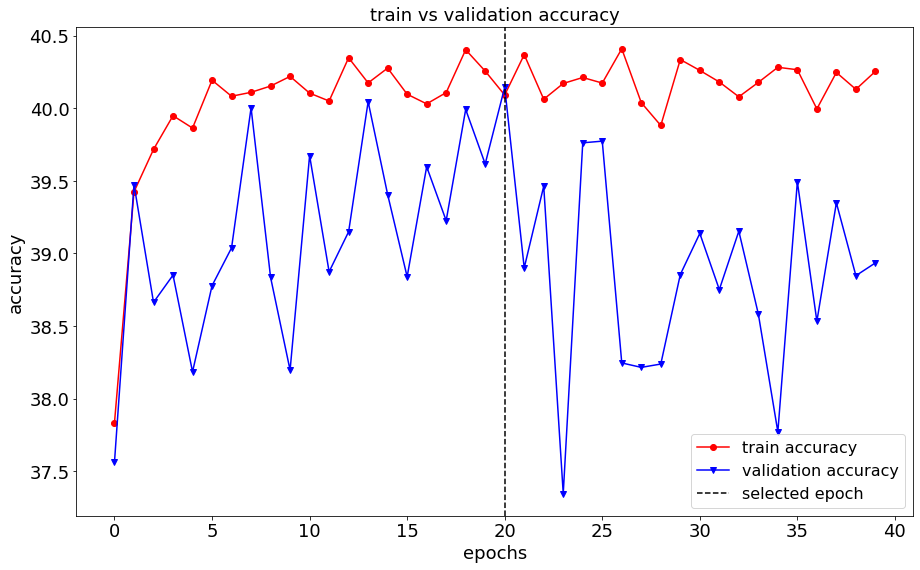

In [43]:
plot_scores('accuracy', train_accs, val_accs, NUM_EPOCHS, selected_epoch)

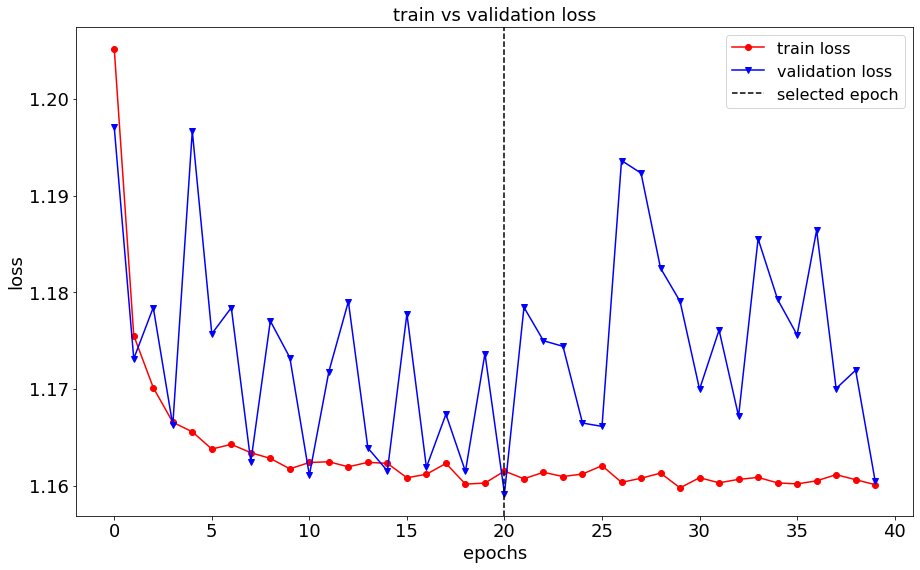

In [44]:
plot_scores('loss', train_losses, val_losses, NUM_EPOCHS, selected_epoch)

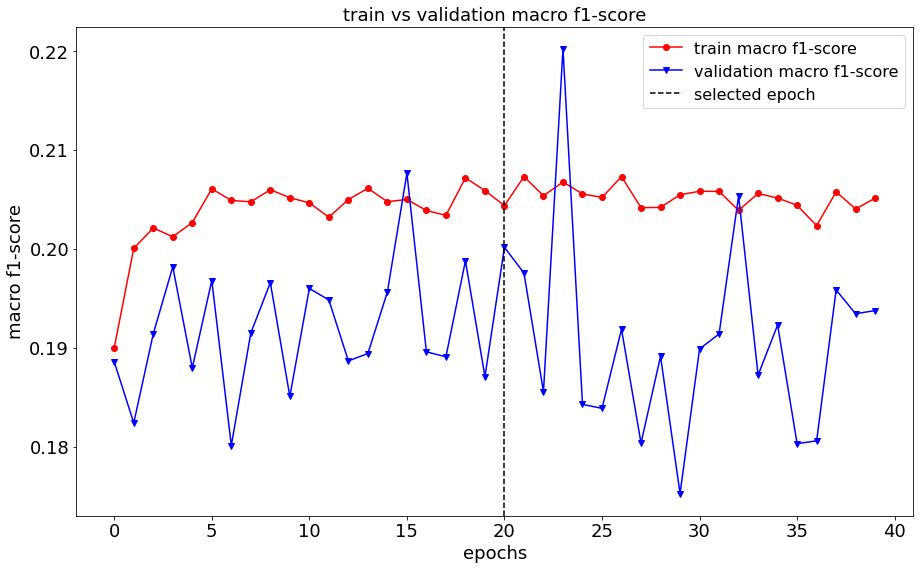

In [45]:
plot_scores('macro f1-score', train_f1s, val_f1s, NUM_EPOCHS, selected_epoch)

In [46]:
eval(model, tm_test_loader)

Test Accuracy: 39.775, Test Macro F1: 0.195
Classwise accuracies: [33.843, 41.441, 63.475, 5.811, 0.0]


# **Cost Sensitive Learning Method-2: Cross Entropy False Error**

In [ ]:
class CrossEntropyFalseErrorLoss(nn.Module):
  def __init__(self):
    super(CrossEntropyFalseErrorLoss, self).__init__()

  def forward(self, outputs, targets):
    #print(outputs, targets)

    num_examples = targets.shape[0]
    batch_size = outputs.shape[0]
    outputs = self._log_softmax(outputs)
    outputs = targets * self._log_softmax(outputs)
    outputs = -1 * outputs

    all_zeroes = torch.zeros_like(targets)
  all_ones = torch.ones_like(targets)

  error_sum = 0.0

  for curr_class in range(5):
    label_tensor = torch.full(targets.size(), curr_class)
    curr_class_pos_mul_tensors = torch.where(targets == label_tensor, all_ones, all_zeroes)
    curr_class_pos_cnt = targets.eq(label_tensor).sum().item()
    curr_class_neg_mul_tensors = torch.where(targets != label_tensor, all_ones, all_zeroes)
    curr_class_neg_cnt = targets.ne(label_tensor).sum().item()

    # print(f'class {curr_class}:\npos count={curr_class_pos_cnt}, neg count={curr_class_neg_cnt}')
    # print(f'pos_mul_tensor={curr_class_pos_mul_tensors}\nneg_mul_tensor={curr_class_neg_mul_tensors}')

    if curr_class_pos_cnt != 0: 
      error_sum += torch.pow(torch.sum(outputs*curr_class_pos_mul_tensors)/curr_class_pos_cnt, 2)
    if curr_class_neg_cnt != 0:
      error_sum += torch.pow(torch.sum(outputs*curr_class_neg_mul_tensors)/curr_class_neg_cnt, 2)

  return error_sum / 5

  def _log_softmax(self, x):
    return x - torch.logsumexp(x,dim=1, keepdim=True)

In [ ]:
# setup the custom loss function
cs2_criterion = CrossEntropyFalseErrorLoss()

## Custom ANN

In [ ]:
# # init model with ANN
# set_global_seed()
# model = ANN(input_size=INPUT_SIZE, fc1_size=ANN_FC1_SIZE, fc2_size=ANN_FC2_SIZE, fc3_size=ANN_FC3_SIZE)
# model = model.to(device)

# # init optimizer
# optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# model,selected_epoch, train_accs,train_losses,train_f1s, val_accs,val_losses,val_f1s = train(model, optimizer, cs2_criterion, train_loader, val_loader, NUM_EPOCHS)

In [ ]:
#plot_scores('accuracy', train_accs, val_accs, NUM_EPOCHS, selected_epoch)

In [ ]:
#plot_scores('loss', train_losses, val_losses, NUM_EPOCHS, selected_epoch)

In [ ]:
#plot_scores('macro f1-score', train_f1s, val_f1s, NUM_EPOCHS, selected_epoch)

In [ ]:
# eval(model, test_loader)

## Custom CNN

In [ ]:
# init model with CNN
set_global_seed()
model = CNN()
model = model.to(device)

# init optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

model,selected_epoch, train_accs,train_losses,train_f1s, val_accs,val_losses,val_f1s = train(model, optimizer, cs2_criterion, train_loader, val_loader, NUM_EPOCHS)

In [ ]:
plot_scores('accuracy', train_accs, val_accs, NUM_EPOCHS, selected_epoch)

In [ ]:
plot_scores('loss', train_losses, val_losses, NUM_EPOCHS, selected_epoch)

In [ ]:
plot_scores('macro f1-score', train_f1s, val_f1s, NUM_EPOCHS, selected_epoch)

In [ ]:
eval(model=model, test_loader=test_loader)

## Transfer Learning

### Resnet-18

In [ ]:
# init model with ResNet-18
set_global_seed()

model = TransferModel('resnet-18')
model = model.to(device)

# init optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

model,selected_epoch, train_accs,train_losses,train_f1s, val_accs,val_losses,val_f1s = train(model, optimizer, cs2_criterion, tm_train_loader, tm_val_loader, NUM_EPOCHS)

In [ ]:
plot_scores('accuracy', train_accs, val_accs, NUM_EPOCHS, selected_epoch)

In [ ]:
plot_scores('loss', train_losses, val_losses, NUM_EPOCHS, selected_epoch)

In [ ]:
plot_scores('macro f1-score', train_f1s, val_f1s, NUM_EPOCHS, selected_epoch)

In [ ]:
eval(model=model, test_loader=tm_test_loader)

### SqueezeNet

In [ ]:
# init model with squeezenet
set_global_seed()

model = TransferModel('squeezenet')
model = model.to(device)

# init optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

model,selected_epoch, train_accs,train_losses,train_f1s, val_accs,val_losses,val_f1s = train(model, optimizer, cs2_criterion, tm_train_loader, tm_val_loader, NUM_EPOCHS)

In [ ]:
plot_scores('accuracy', train_accs, val_accs, NUM_EPOCHS, selected_epoch)

In [ ]:
plot_scores('loss', train_losses, val_losses, NUM_EPOCHS, selected_epoch)

In [ ]:
plot_scores('macro f1-score', train_f1s, val_f1s, NUM_EPOCHS, selected_epoch)

In [ ]:
eval(model, tm_test_loader)